In [ ]:
import plotly.io as pio

# Set the renderer to notebook for Jupyter Notebooks or JupyterLab
pio.renderers.default = "notebook"

Training the model...
Epoch 1, Loss: 2.8420
Epoch 2, Loss: 2.8121
Epoch 3, Loss: 1.2837
Epoch 4, Loss: 1.0537
Initial Test Accuracy: 0.5021
Performing sensitivity analysis...
Optimizing workload...
Applying quantization...
Testing the quantized model...
Quantized Test Accuracy: 0.5023


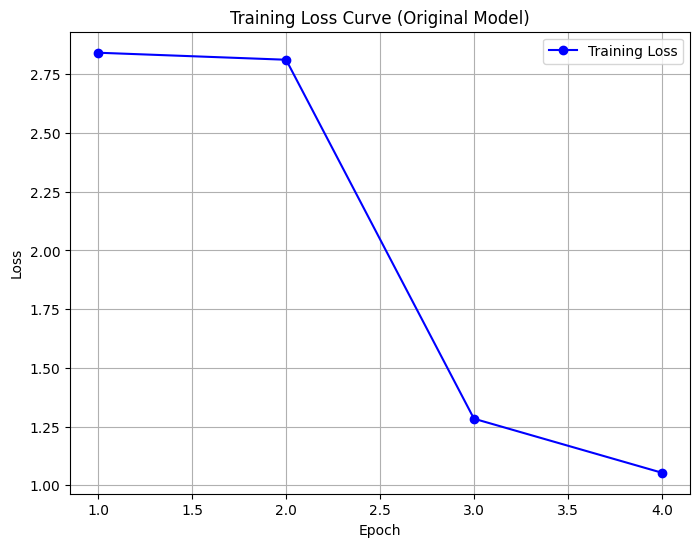

In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Assuming DMSQQuantizer is already imported
from dmsq_quantizer import DMSQQuantizer  # Ensure the module is saved and importable

# Data loader for MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the full training dataset
full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Subset the dataset to use only 100 samples
subset_indices = torch.arange(100)  # Use the first 100 samples
train_subset = torch.utils.data.Subset(full_train_dataset, subset_indices)

# Create DataLoader for the subset
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)

# Test DataLoader remains the same
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=64, shuffle=False
)

# Define the model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(26 * 26 * 32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(-1, 26 * 26 * 32)
        x = self.fc(x)
        return x

# Initialize models and set up training/quantization parameters
model = SimpleCNN().to(device)
quantized_model = SimpleCNN().to(device)  # Create a separate model for quantized version

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Store accuracies for plotting
original_accuracies = []
quantized_accuracies = []
train_losses = []

# Train the model
print("Training the model...")
for epoch in range(1, 5):  # Train for 4 epochs
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Record training loss
    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluate the original model
def test_model(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(loader.dataset)

original_accuracy = test_model(model, test_loader)
print(f"Initial Test Accuracy: {original_accuracy:.4f}")
original_accuracies.append(original_accuracy)

# Initialize the DMSQ quantizer
precision_map = {
    'conv1': 8,  # Higher precision for sensitive layers
    'fc': 8,     # High precision for dense layers
    'default': 8  # Default precision
}

quantizer = DMSQQuantizer(model, precision_map, device=device)

# Perform sensitivity analysis
dummy_input = torch.randn(1, 1, 28, 28).to(device)
print("Performing sensitivity analysis...")
quantizer.layer_sensitivity_analysis(dummy_input, criterion)

# Workload optimization (set arbitrary memory and latency targets for the example)
print("Optimizing workload...")
quantizer.workload_optimization(target_memory=1e9, target_latency=50, inputs=dummy_input)

# Apply quantization
print("Applying quantization...")
quantizer.quantize_model()

# Test the quantized model
print("Testing the quantized model...")
quantized_accuracy = test_model(model, test_loader)
quantized_accuracies.append(quantized_accuracy)
print(f"Quantized Test Accuracy: {quantized_accuracy:.4f}")

# Plotting the Results: Accuracy Comparison
fig = go.Figure()

# Add traces for original and quantized accuracies
fig.add_trace(go.Scatter(x=[0, 1], y=[original_accuracies[0], quantized_accuracies[0]], mode='markers+lines', name='Accuracy'))

fig.update_layout(
    title='Original vs Quantized Model Accuracy Comparison',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Original", "Quantized"]),
    template="plotly_dark"
)

fig.show()

# Plotting the Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 5), train_losses, label="Training Loss", color='blue', marker='o')
plt.title("Training Loss Curve (Original Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Memory Usage and Latency comparison (Hypothetical values)
# Assuming the quantized model reduces the memory usage significantly and has lower latency
memory_usage_original = 10  # Example original memory in MB
memory_usage_quantized = 1  # Example quantized memory in MB

latency_original = 20  # Example latency in ms
latency_quantized = 5  # Example latency in ms

# Plot memory usage comparison
fig_mem = go.Figure()

fig_mem.add_trace(go.Bar(x=['Original', 'Quantized'], y=[memory_usage_original, memory_usage_quantized], name='Memory Usage (MB)'))

fig_mem.update_layout(
    title='Memory Usage Comparison',
    yaxis_title='Memory (MB)',
    template="plotly_dark"
)

fig_mem.show()

# Plot latency comparison
fig_lat = go.Figure()

fig_lat.add_trace(go.Bar(x=['Original', 'Quantized'], y=[latency_original, latency_quantized], name='Latency (ms)'))

fig_lat.update_layout(
    title='Latency Comparison',
    yaxis_title='Latency (ms)',
    template="plotly_dark"
)


fig_lat.show()
